# Planet Amazon Image Classification - Deep Learning

The labels can broadly be broken into three groups: atmospheric conditions, common land cover/land use phenomena, and rare land cover/land use phenomena. Each chip will have one and potentially more than one atmospheric label and zero or more common and rare labels.
The common labels in this data set are rainforest, agriculture, rivers, towns/cities, and roads. The overwhelming majority of the data set is labeled as "primary"

## Importing the Data

In [1]:
#import modules
import numpy as np 
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from IPython.display import display
from skimage import io
%matplotlib inline

# Define files and directories
os.chdir('C:/Users/isado/Documents/SpringBoard/Capstone2/')
         
# Create DataFrame with training labels
train_labels = pd.read_csv('./train_classes.csv')

train_labels

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [2]:
#Extracting unique labels
labels = []
for tags in train_labels.tags.values:
    label = tags.split(' ')
    for subitem in label:
        if subitem not in labels:
            labels.append(subitem)

#One Hot encoding labels
for label in labels:
    train_labels[label] = train_labels['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    
train_labels.index = train_labels.image_name
train_labels

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
image_name,,,,,,,,,,,,,,,,,,,
train_0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
train_1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
train_2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
train_3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
train_4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_40474,train_40474,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
train_40475,train_40475,cloudy,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
train_40476,train_40476,agriculture clear primary,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


(64, 64, 3)


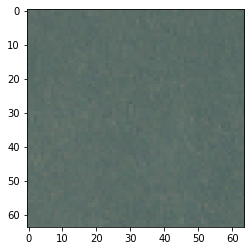

In [3]:
from skimage.transform import resize

#Write function to get a specific image, resize to 64x64

def load_image(file_name, fig_type='jpg', new_size=64):
    img_path = ('./train-{}/{}.{}').format(fig_type,file_name,fig_type)
    img = io.imread(img_path)
    img = resize(img, (new_size,new_size,3), mode='constant')
    
    return img

image = load_image('train_0')
plt.imshow(image)
print(image.shape)

In [4]:
#Create a lookup dictionary containing the labels for each image sample

labels_dict={}
labels_array = np.array(train_labels.iloc[:,-17:])

for i, sample in enumerate(train_labels.index):
    labels_dict[sample] = labels_array[i]

labels_dict['train_0']

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [5]:
# def progressbar(it, prefix="", size=60, file=sys.stdout):
#     count = len(it)
#     def show(j):
#         x = int(size*j/count)
#         file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
#         file.flush()        
#     show(0)
#     for i, item in enumerate(it):
#         yield item
#         show(i+1)
#     file.write("\n")

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# import keras library
import keras

# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

C:\Users\isado\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
#RAM size limitation makes it so we have to process our data in mini-batches

from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

#adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.Sequence):
    
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=64, dim=(64,64), n_channels=3,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = list(np.empty((self.batch_size)))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = load_image(ID, new_size=self.dim[0])

            # Store class
            y[i] = self.labels[ID]

        return X, np.array(y)

In [19]:
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# # examine number of samples in train, test, and validation sets
# print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')

In [23]:
#Neural Net building

# Parameters
params = {'dim': (64,64),
          'batch_size': 256,
          'n_classes': 17,
          'n_channels': 3,
          'shuffle': True}

# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Save the best model as best_amazonimages_model.hdf5
modelCheckpoint = ModelCheckpoint('best_amazonimages_model.hdf5', save_best_only = True)

# Define a callback to monitor validation accuracy
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

# Generators
training_generator = DataGenerator(train_labels.index[0:2000], labels_dict, **params)
validation_generator = DataGenerator(train_labels.index[2000:2667], labels_dict, **params)

#Design Model################################

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(4,4)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# add dropout to prevent over fitting
model.add(Dropout(0.5))

# necessary flatten step preceeding dense layer
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting
model.add(Dropout(0.5))

# prediction layers
model.add(Dense(17, activation='sigmoid', name='preds'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=["accuracy"])

# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs = 50, callbacks=[monitor_val_acc, modelCheckpoint],
                    use_multiprocessing=False,
                    workers=4)

Epoch 1/50
7/7 [==============================] - 124s 18s/step - loss: 0.4952 - accuracy: 0.7935 - val_loss: 0.3403 - val_accuracy: 0.9014
Epoch 2/50
7/7 [==============================] - 123s 18s/step - loss: 0.3894 - accuracy: 0.8675 - val_loss: 0.3229 - val_accuracy: 0.8997
Epoch 3/50
7/7 [==============================] - 115s 16s/step - loss: 0.3527 - accuracy: 0.8812 - val_loss: 0.2994 - val_accuracy: 0.9017
Epoch 4/50
7/7 [==============================] - 111s 16s/step - loss: 0.3178 - accuracy: 0.8860 - val_loss: 0.2710 - val_accuracy: 0.9013
Epoch 5/50
7/7 [==============================] - 113s 16s/step - loss: 0.2982 - accuracy: 0.8936 - val_loss: 0.2804 - val_accuracy: 0.8997
Epoch 6/50
7/7 [==============================] - 113s 16s/step - loss: 0.2857 - accuracy: 0.8971 - val_loss: 0.2579 - val_accuracy: 0.9020
Epoch 7/50
7/7 [==============================] - 115s 16s/step - loss: 0.2797 - accuracy: 0.8984 - val_loss: 0.2549 - val_accuracy: 0.9042
Epoch 8/50
7/7 [====

In [15]:
def plot_loss(loss,val_loss):
    """Plots loss as a function of epoch for validation 
           and training sets"""
    
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

def plot_accuracy(acc,val_acc):
    """Plots loss as a function of epoch for validation 
           and training sets"""
    
    plt.figure()
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

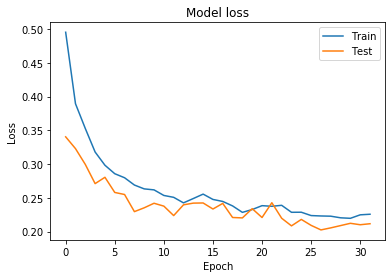

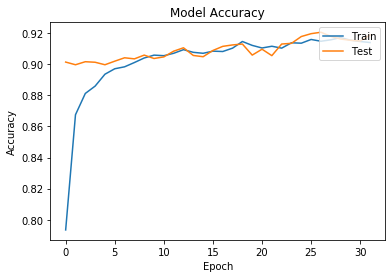

In [30]:
# Plot train vs test loss during training
plot_loss(history.history['loss'], history.history['val_loss'])

# Plot train vs test accuracy during training
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

In [33]:
#Checking effects of adding batch normalization

from keras.layers import BatchNormalization

# Parameters
params = {'dim': (64,64),
          'batch_size': 256,
          'n_classes': 17,
          'n_channels': 3,
          'shuffle': True}

# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Save the best model as best_amazonimages_model.hdf5
modelCheckpoint = ModelCheckpoint('best_amazonimages_model_batchnorm.hdf5', save_best_only = True)

# Define a callback to monitor validation accuracy
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

# Generators
training_generator = DataGenerator(train_labels.index[0:2000], labels_dict, **params)
validation_generator = DataGenerator(train_labels.index[2000:2667], labels_dict, **params)

#Design Model################################

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(4,4)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# add dropout to prevent over fitting
model.add(Dropout(0.5))

# necessary flatten step preceeding dense layer
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

# add additional dropout to prevent overfitting
model.add(Dropout(0.5))

# prediction layers
model.add(Dense(17, activation='sigmoid', name='preds'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=["accuracy"])

# Train model on dataset
history_batchnorm = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs = 50, callbacks=[monitor_val_acc, modelCheckpoint],
                    use_multiprocessing=False,
                    workers=4)

Epoch 1/50
7/7 [==============================] - 133s 19s/step - loss: 0.7252 - accuracy: 0.5765 - val_loss: 0.6827 - val_accuracy: 0.9003
Epoch 2/50
7/7 [==============================] - 116s 17s/step - loss: 0.6713 - accuracy: 0.6696 - val_loss: 0.6712 - val_accuracy: 0.8742
Epoch 3/50
7/7 [==============================] - 122s 17s/step - loss: 0.6554 - accuracy: 0.7181 - val_loss: 0.6567 - val_accuracy: 0.8949
Epoch 4/50
7/7 [==============================] - 120s 17s/step - loss: 0.6354 - accuracy: 0.7393 - val_loss: 0.6379 - val_accuracy: 0.8988
Epoch 5/50
7/7 [==============================] - 134s 19s/step - loss: 0.6147 - accuracy: 0.8018 - val_loss: 0.6144 - val_accuracy: 0.9052
Epoch 6/50
7/7 [==============================] - 122s 17s/step - loss: 0.5847 - accuracy: 0.8306 - val_loss: 0.5855 - val_accuracy: 0.9053
Epoch 7/50
7/7 [==============================] - 116s 17s/step - loss: 0.5537 - accuracy: 0.8605 - val_loss: 0.5553 - val_accuracy: 0.8997
Epoch 8/50
7/7 [====

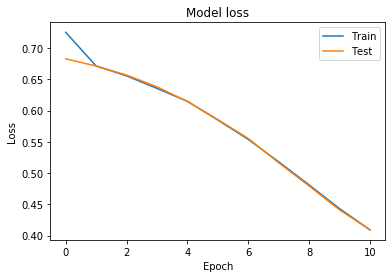

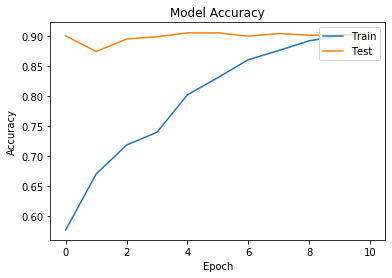

In [34]:
# Plot train vs test loss during training
plot_loss(history_batchnorm.history['loss'], history_batchnorm.history['val_loss'])

# Plot train vs test accuracy during training
plot_accuracy(history_batchnorm.history['accuracy'], history_batchnorm.history['val_accuracy'])

In [35]:
#Modifying batch size

# Parameters
params = {'dim': (64,64),
          'batch_size': 128,
          'n_classes': 17,
          'n_channels': 3,
          'shuffle': True}

# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Save the best model as best_amazonimages_model.hdf5
modelCheckpoint = ModelCheckpoint('best_amazonimages_model128.hdf5', save_best_only = True)

# Define a callback to monitor validation accuracy
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

# Generators
training_generator = DataGenerator(train_labels.index[0:2000], labels_dict, **params)
validation_generator = DataGenerator(train_labels.index[2000:2667], labels_dict, **params)

#Design Model################################

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(4,4)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# add dropout to prevent over fitting
model.add(Dropout(0.5))

# necessary flatten step preceeding dense layer
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting
model.add(Dropout(0.5))

# prediction layers
model.add(Dense(17, activation='sigmoid', name='preds'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=["accuracy"])

# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs = 50, callbacks=[monitor_val_acc, modelCheckpoint],
                    use_multiprocessing=False,
                    workers=4)

Epoch 1/50
15/15 [==============================] - 141s 9s/step - loss: 0.4511 - accuracy: 0.8158 - val_loss: 0.3324 - val_accuracy: 0.9011
Epoch 2/50
15/15 [==============================] - 132s 9s/step - loss: 0.3306 - accuracy: 0.8824 - val_loss: 0.2610 - val_accuracy: 0.9006
Epoch 3/50
15/15 [==============================] - 121s 8s/step - loss: 0.2945 - accuracy: 0.8937 - val_loss: 0.2840 - val_accuracy: 0.9018
Epoch 4/50
15/15 [==============================] - 121s 8s/step - loss: 0.2779 - accuracy: 0.8983 - val_loss: 0.2444 - val_accuracy: 0.9010
Epoch 5/50
15/15 [==============================] - 120s 8s/step - loss: 0.2671 - accuracy: 0.9010 - val_loss: 0.2555 - val_accuracy: 0.9041
Epoch 6/50
15/15 [==============================] - 120s 8s/step - loss: 0.2620 - accuracy: 0.9026 - val_loss: 0.2412 - val_accuracy: 0.9026
Epoch 7/50
15/15 [==============================] - 121s 8s/step - loss: 0.2569 - accuracy: 0.9036 - val_loss: 0.2468 - val_accuracy: 0.9047
Epoch 8/50
15

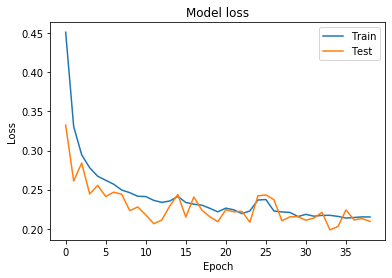

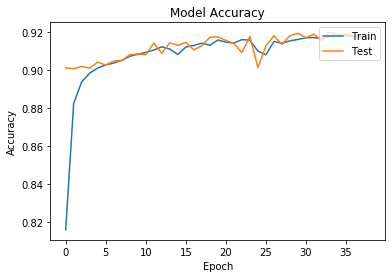

In [36]:
# Plot train vs test loss during training
plot_loss(history.history['loss'], history.history['val_loss'])

# Plot train vs test accuracy during training
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

In [ ]:
# Building an autoencoder?
# Autoencoders have several interesting applications like anomaly detection or image denoising. They aim at producing an output identical to its inputs. The input will be compressed into a lower dimensional space, encoded. The model then learns to decode it back to its original form.

# The hidden layer will encode a lower n-dimensional representation of the image


In [8]:
#Increasing the size of the training/validation set

# Parameters
params = {'dim': (64,64),
          'batch_size': 256,
          'n_classes': 17,
          'n_channels': 3,
          'shuffle': True}

# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Save the best model as best_amazonimages_model.hdf5
modelCheckpoint = ModelCheckpoint('best_amazonimages_6000samples.hdf5', save_best_only = True)

# Define a callback to monitor validation accuracy
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

# Generators
training_generator = DataGenerator(train_labels.index[0:4500], labels_dict, **params)
validation_generator = DataGenerator(train_labels.index[4500:6000], labels_dict, **params)

#Design Model################################

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(4,4)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# add dropout to prevent over fitting
model.add(Dropout(0.5))

# necessary flatten step preceeding dense layer
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting
model.add(Dropout(0.5))

# prediction layers
model.add(Dense(17, activation='sigmoid', name='preds'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=["accuracy"])

# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs = 50, callbacks=[monitor_val_acc, modelCheckpoint],
                    use_multiprocessing=False,
                    workers=4)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50


C:\Users\isado\Anaconda3\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


17/17 [==============================] - 352s 21s/step - loss: 0.4524 - accuracy: 0.8245 - val_loss: 0.3063 - val_accuracy: 0.9082
Epoch 2/50
17/17 [==============================] - 274s 16s/step - loss: 0.3330 - accuracy: 0.8842 - val_loss: 0.2693 - val_accuracy: 0.9069
Epoch 3/50
17/17 [==============================] - 285s 17s/step - loss: 0.2870 - accuracy: 0.8952 - val_loss: 0.2489 - val_accuracy: 0.9081
Epoch 4/50
17/17 [==============================] - 300s 18s/step - loss: 0.2701 - accuracy: 0.8993 - val_loss: 0.2381 - val_accuracy: 0.9093
Epoch 5/50
17/17 [==============================] - 259s 15s/step - loss: 0.2591 - accuracy: 0.9025 - val_loss: 0.2350 - val_accuracy: 0.9098
Epoch 6/50
17/17 [==============================] - 276s 16s/step - loss: 0.2520 - accuracy: 0.9044 - val_loss: 0.2357 - val_accuracy: 0.9087
Epoch 7/50
17/17 [==============================] - 278s 16s/step - loss: 0.2469 - accuracy: 0.9063 - val_loss: 0.2501 - val_accuracy: 0.9097
Epoch 8/50
17/17 

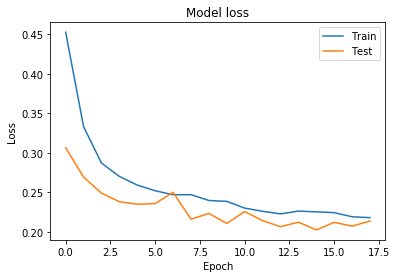

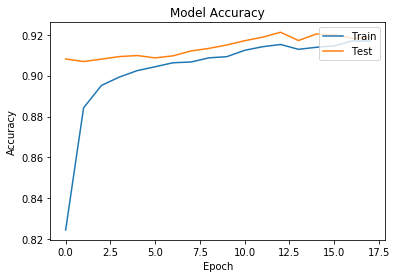

In [16]:
# Plot train vs test loss during training
plot_loss(history.history['loss'], history.history['val_loss'])

# Plot train vs test accuracy during training
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

In [62]:
# Evaluating model using test set
params = {'dim': (64,64),
          'batch_size': 256,
          'n_classes': 17,
          'n_channels': 3,
          'shuffle': False}

test_set = train_labels.index[6000:7024]

test_generator = DataGenerator(test_set, labels_dict, **params)

# make predictions on the testing images
preds = model.predict_generator(test_generator,steps=len(test_set)//params['batch_size'],verbose=1)

truelabels = train_labels.loc[test_set].iloc[:,-17:].values

4/4 [==============================] - 20s 5s/step


In [88]:
from sklearn.metrics import accuracy_score

preds_threshold = np.zeros(truelabels.shape)

for threshold in np.arange(0.1,0.9,0.05):
    i = 0
    for sample in preds:
        preds_threshold[i] = [1 if class_proba>threshold else 0 for class_proba in sample]
        i += 1
    
    accuracy = accuracy_score(truelabels, preds_threshold)
    print('Threshold:{thresh: .2f} Accuracy:{acc: .3f}'.format(thresh = threshold, acc = accuracy))  

Threshold: 0.10 Accuracy: 0.093
Threshold: 0.15 Accuracy: 0.204
Threshold: 0.20 Accuracy: 0.266
Threshold: 0.25 Accuracy: 0.316
Threshold: 0.30 Accuracy: 0.363
Threshold: 0.35 Accuracy: 0.379
Threshold: 0.40 Accuracy: 0.379
Threshold: 0.45 Accuracy: 0.374
Threshold: 0.50 Accuracy: 0.368
Threshold: 0.55 Accuracy: 0.359
Threshold: 0.60 Accuracy: 0.350
Threshold: 0.65 Accuracy: 0.344
Threshold: 0.70 Accuracy: 0.325
Threshold: 0.75 Accuracy: 0.303
Threshold: 0.80 Accuracy: 0.271
Threshold: 0.85 Accuracy: 0.230


In [89]:
# Breakdown accuracy per class? Focus on rare classes?
# Calculate variance,skewness,kurtosis and entropy?
# Grayscale images with higher resolution?
# Evaluate more training sizes?

In [90]:
# Hyperparameter Tuning using RandomSearchCV

# Import KerasClassifier from keras wrappers
# from keras.wrappers.scikit_learn import KerasClassifier

# # Create a KerasClassifier
# model = KerasClassifier(build_fn = create_model)

# # Define the parameters to try out
# params = {'activation': ['relu','tanh'], 'batch_size': [32,128,256], 
#           'epochs': [50,100,200], 'learning_rate': [0.1,0.01,0.001]}

# # Create a randomize search cv object passing in the parameters to try
# random_search = RandomizedSearchCV(model, param_distributions = params, cv = KFold(3))

# # Running random_search.fit(X,y) would start the search,but it takes too long! 
# show_results()